In [13]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

from collections import defaultdict
from os.path import join
from comm_data import preprocess

import sys
sys.path.append("..")

from seal.trainer.communication import *

RESULTS_DIR = "results"
HUE_ORDER = ["Federated", "Centralized", "Decentralized"]
STYLE_ORDER = ["Federated", "Centralized", "Decentralized"]

plt.style.use(['science', 'ieee', 'no-latex'])
# sns.set_context("notebook")
# sns.set_style("ticks")
major, minor = 5.0, 3.0

In [2]:
base_path = ("..", "out", "data")
dfs = []
for intersection in ["grid-3x3", "grid-5x5", "grid-7x7"]:
    for ranked in [False]:
        ranked_str = "ranked" if ranked else "unranked"
        paths = [
            join(*base_path, "MARL",  intersection, f"v4_{ranked_str}.csv"),
            join(*base_path, "SARL",  intersection, f"v4_{ranked_str}.csv"),
            join(*base_path, "FedRL", intersection, f"v4_naive-aggr_{ranked_str}.csv"),
        ]
        dfs.extend([
            preprocess(path, intersection=intersection)
            for path in paths
        ])

df = pd.concat(dfs)
df.reset_index(inplace=True)
df.head()

,index,tls-to-edge-obs-comms,edge-to-tls-rank-comms,veh-to-tls-info-comms,edge-to-tls-action-comms,edge-to-tls-policy-comms,tls-to-edge-policy-comms,trainer,iteration,round,intersection,timesteps_total,ranked,weight_aggr_fn,episode_reward_mean,episode,total_comm_cost,tls
0,0,0,0,1029,0,0,0,Decentralized,1,0,Grid-3x3,4000,False,N/A,-9.836773,0,1029,A2
1,1,0,0,987,0,0,0,Decentralized,1,0,Grid-3x3,4000,False,N/A,-9.836773,0,987,C2
2,2,0,0,972,0,0,0,Decentralized,1,0,Grid-3x3,4000,False,N/A,-9.836773,0,972,B1
3,3,0,0,1165,0,0,0,Decentralized,1,0,Grid-3x3,4000,False,N/A,-9.836773,0,1165,B2
4,4,0,0,846,0,0,0,Decentralized,1,0,Grid-3x3,4000,False,N/A,-9.836773,0,846,A1


In [3]:
# sns.lineplot(data=df, x="timesteps_total", y="veh-to-tls-info-comms", hue="trainer")
# plt.show()

In [4]:
df["intersection"].unique()

array(['Grid-3x3', 'Grid-5x5', 'grid-7x7'], dtype=object)

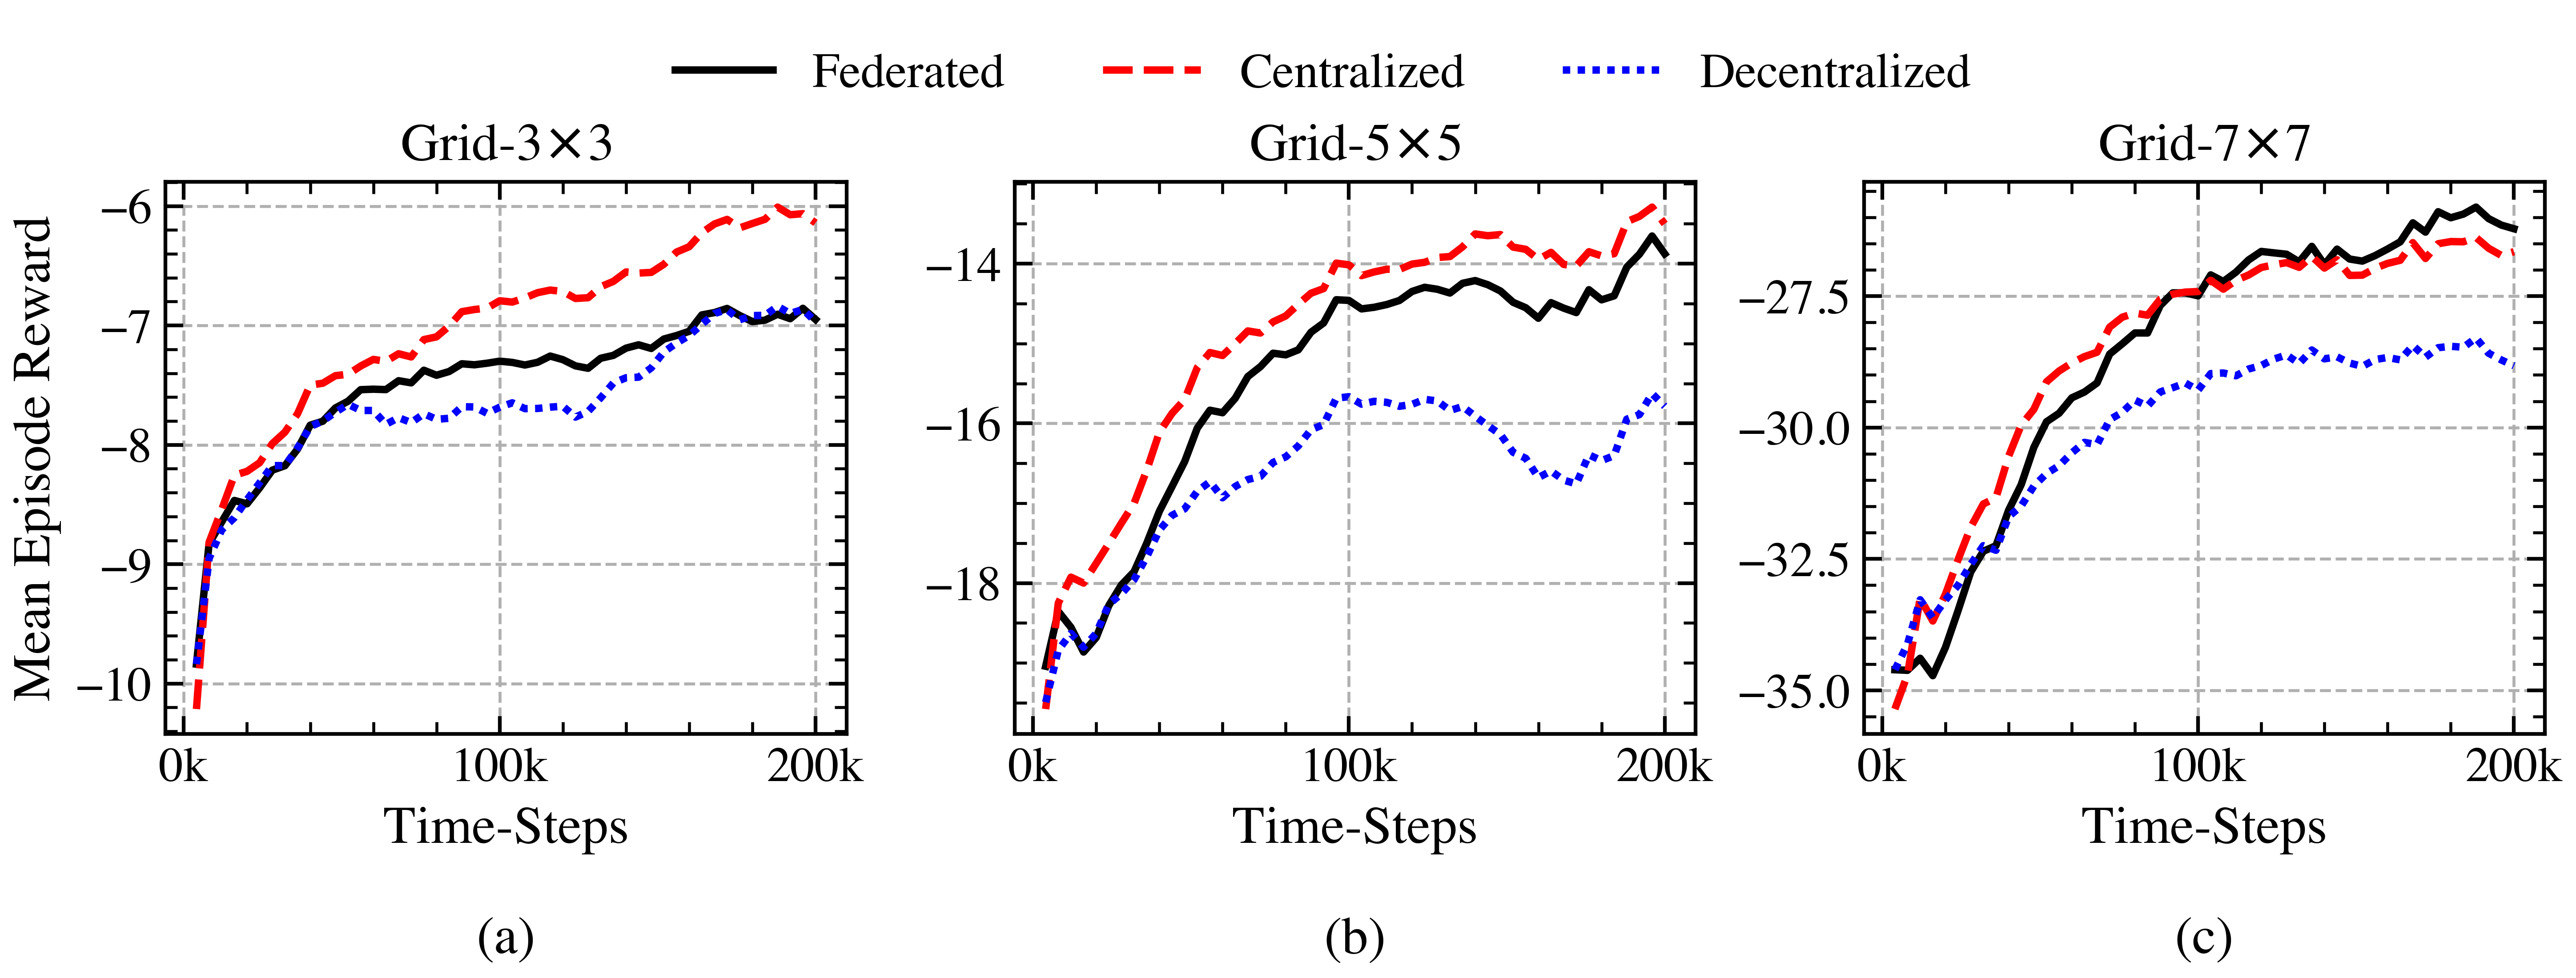

In [23]:
with sns.plotting_context("paper", font_scale=1.5):
    NCOLS = 3
    fig, axes = plt.subplots(ncols=NCOLS, figsize=(10, 4))
    for (col, intersection) in enumerate(["Grid-3x3", "Grid-5x5", "grid-7x7"]):
        query = f"intersection == '{intersection}'"
        sns.lineplot(
            data=df.query(query),
            x="timesteps_total",
            y="episode_reward_mean",
            hue="trainer",
            hue_order=HUE_ORDER,
            style="trainer",
            style_order=STYLE_ORDER,
            ci=None,
            ax=axes[col],
            linewidth=2
        )
        # labels = axes[row, col].get_xticklabels()
        # axes[row, col].set_xticklabels(labels, rotation=20)
        axes[col].grid(which="major", linestyle="--")
        axes[col].set_xlabel("Time-Steps")
        axes[col].set_ylabel("Mean Episode Reward")
        axes[col].set_xticklabels(["", "0k", "100k", "200k"])
        handles, labels = axes[col].get_legend_handles_labels()
        axes[col].get_legend().remove()
        title = f"\n\n{intersection}".title().replace("X", "$\\times$")
        axes[col].set_title(title)

    for col in range(1, NCOLS):
        axes[col].set_ylabel("")

    for label, col in zip(["a", "b", "c"], range(NCOLS)):
        axes[col].set_xlabel(f"Time-Steps\n\n({label})")

    handles = [copy.copy(ha) for ha in handles]
    [ha.set_linewidth(2) for ha in handles]
    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5125, 0.95))
    # fig.suptitle("\n")
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, "training_reward.pdf"))
    plt.show()

# Communication Cost Analysis
Here, we perform analysis of the cost associated with each of the training approaches. To do this, our code tracked `6` different kinds of communications:
* `tls-to-edge-policy-comms`
* `edge-to-tls-action-comms`
* `edge-to-tls-rank-comms`
* `edge-to-tls-policy-comms`
* `veh-to-tls-info-comms`
* `tls-to-edge-obs-comms`

During the training, we track the number of occurrences of each of the communication types. This is then so we can do analysis via post-processing where the byte sizes of each data type is applied as weights to get a better sense of the actual communication type.

First, we define a function, `comm_df_fn(.)`, that creates an auxialiary `DataFrame` with a new column, `weighted_comm_cost`. This function takes a dictionary of weights for the `6` communication types (mentioned above) and then applies them to make a weighted sum.

In [ ]:
def comm_df_fn(weights: dict=None) -> pd.DataFrame:
    if weights is None:
        weights = {}
    for comm_type in COMM_TYPES:
        if comm_type not in weights:
            weights[comm_type] = 1.0

    def fn(row):
        weighted_total =  sum(
            row[comm_type] * weights[comm_type] 
            for comm_type in COMM_TYPES
        )
        weighted_total += sum(
            row[comm_type] * weights["hops-to-edge"]
            for comm_type in COMM_TYPES
            if "edge" in comm_type
        )
        return weighted_total

    comm_df = df.copy()
    comm_df["weighted_comm_cost"] = df.apply(lambda row: fn(row), axis=1)
    return comm_df

It is important to note that this analysis is limited to the fact that the state space representation of our approach is very simple. In a real-world implementation, we may want to include live video feed as a feature of a state space. Such data would be much more costly than a relatively small vector (i.e., either $1\times14$ for ranked or $1\times10$ for unranked) of floats.

The values for the byte size weights can be found in the sibling `Data Transmission Sizes` notebook.

In [ ]:
comm_weights = {
    'hops-to-edge': 1,
    'edge-to-tls-rank-comms':   112, 
    'tls-to-edge-obs-comms':    136, 
    'tls-to-edge-policy-comms': 640, 
    'edge-to-tls-policy-comms': 640, 
    'veh-to-tls-info-comms':    108, 
    'edge-to-tls-action-comms': 24
}

comm_df = comm_df_fn(comm_weights)
comm_df.head()

## Weighted Communication Cost

In [ ]:
with sns.plotting_context("paper", font_scale=1.5):
    NROWS, NCOLS = 2, 3
    fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6, 4))
    for (col, intersection) in enumerate(["Grid-3x3", "Grid-5x5", "grid-7x7"]):
        query = f"intersection == '{intersection}' and ranked == {ranked}"
        sns.lineplot(
            data=comm_df.query(query),
            x="timesteps_total",
            y="weighted_comm_cost",
            hue="trainer",
            hue_order=HUE_ORDER,
            style="trainer",
            style_order=STYLE_ORDER,
            ci=None,
            ax=axes[row, col]
        )
        # labels = axes[row, col].get_xticklabels()
        # axes[row, col].set_xticklabels(labels, rotation=20)
        axes[row, col].grid(which="major", linestyle="--")
        axes[row, col].set_title(f"{intersection}")
        axes[row, col].set_xlabel("Time-Steps")

        # Simplify the x- and y-ticks on the individual axes.
        xlabels = ['{:,.0f}'.format(x) + 'k' for x in axes[row, col].get_xticks()/1000]
        axes[row, col].set_xticklabels(xlabels)

        ylabels = ['{:,.0f}'.format(x) + 'k' for x in axes[row, col].get_yticks()/1000]
        axes[row, col].set_yticklabels(ylabels)
        # axes[row, col].ticklabel_format(axis="y", style="scientific")

        axes[row, col].set_ylabel("# Bytes")
        handles, labels = axes[row, col].get_legend_handles_labels()
        axes[row, col].get_legend().remove()

    for row in range(NROWS):
        for col in range(1, NCOLS):
            axes[row, col].set_ylabel("")

    for label, col in zip(["a", "b", "c"], range(NCOLS)):
        axes[NROWS-1, col].set_xlabel(f"Time-Steps\n\n({label})")

    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    fig.suptitle("Weighted Total Communication Cost\n")
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, "weighted_total_comm_cost.pdf"))
    plt.show()

## Unweighted Total Communication

In [ ]:
with sns.plotting_context(font_scale=1.15):
    NROWS, NCOLS = 2, 3
    fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6, 4))
    for (row, ranked) in enumerate([True, False]):
        for (col, intersection) in enumerate(["Grid-3x3", "Grid-5x5", "grid-7x7"]):
            query = f"intersection == '{intersection}' and ranked == {ranked}"
            sns.lineplot(
                data=df.query(query),
                x="timesteps_total",
                y="total_comm_cost",
                hue="trainer",
                hue_order=HUE_ORDER,
                style="trainer",
                style_order=STYLE_ORDER,
                ci=None,
                ax=axes[row, col]
            )
            # labels = axes[row, col].get_xticklabels()
            # axes[row, col].set_xticklabels(labels, rotation=20)
            axes[row, col].grid(which="major", linestyle="--")
            axes[row, col].set_title(f"{intersection} ({'Ranked' if ranked else 'Unranked'})")
            axes[row, col].set_xlabel("Time-Steps")

            # Simplify the x- and y-ticks on the individual axes.
            xlabels = ['{:,.1f}'.format(x) + 'k' for x in axes[row, col].get_xticks()/1000]
            axes[row, col].set_xticklabels(xlabels)

            ylabels = ['{:,.1f}'.format(x) + 'k' for x in axes[row, col].get_yticks()/1000]
            axes[row, col].set_yticklabels(ylabels)
            # axes[row, col].ticklabel_format(axis="y", style="scientific")

            axes[row, col].set_ylabel("# Bytes")
            handles, labels = axes[row, col].get_legend_handles_labels()
            axes[row, col].get_legend().remove()

    for row in range(NROWS):
        for col in range(1, NCOLS):
            axes[row, col].set_ylabel("")

    for label, col in zip(["a", "b", "c"], range(NCOLS)):
        axes[NROWS-1, col].set_xlabel(f"Time-Steps\n\n({label})")

    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    fig.suptitle("Unweighted Total Communication Cost\n")
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, "unweighted_total_comm_cost.pdf"))
    plt.show()

## Communication Cost Analysis: Hops-to-Edge-RSU
TODO: Adjust how the number of `hops` affects the overall communication cost.

Consider the distance between vehicles and the traffic light as $d_{1}$ and the distance between the traffic light and the Edge-RSU as $d_{2}$. Then set
$$d_{2} = k \cdot d_{1}$$
where $k$ is the number of hops. This way we can see how the $k$ parameter affects the overall communication cost.

In [ ]:
# Make AUXILIARY DataFrame that features a `hops-to-edge` column
temp_comm_df = []
for hops in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    temp_df = comm_df_fn(dict(comm_weights, **{'hops-to-edge': hops}))
    temp_df["hops-to-edge"] = [hops] * len(temp_df)
    temp_comm_df.append(temp_df)
temp_comm_df = pd.concat(temp_comm_df)
temp_comm_df.reset_index(inplace=True)

In [ ]:
# Plot the results.
with sns.plotting_context(font_scale=1.15):
    NROWS, NCOLS = 2, 3
    fig, axes = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6, 4))
    for (row, ranked) in enumerate([True, False]):
        for (col, intersection) in enumerate(["Grid-3x3", "Grid-5x5", "grid-7x7"]):
            query = f"intersection == '{intersection}' and ranked == {ranked}"
            sns.lineplot(
                data=temp_comm_df.query(query),
                x="hops-to-edge",
                y="weighted_comm_cost",
                hue="trainer",
                hue_order=HUE_ORDER,
                markers=True,
                style="trainer",
                style_order=STYLE_ORDER,
                ci=None,#95,
                err_style="bars",
                ax=axes[row, col]
            )
            
            axes[row, col].grid(which="major", linestyle="--")
            axes[row, col].set_title(f"{intersection} ({'Ranked' if ranked else 'Unranked'})")
            axes[row, col].set_xlabel("# Hops-to-Edge-RSU")

            ylabels = ['{:,.0f}'.format(x) + 'k' for x in axes[row, col].get_yticks()/1000]
            axes[row, col].set_yticklabels(ylabels)

            axes[row, col].set_ylabel("Avg. # Bytes")
            handles, labels = axes[row, col].get_legend_handles_labels()
            axes[row, col].get_legend().remove()

    for row in range(NROWS):
        for col in range(1, NCOLS):
            axes[row, col].set_ylabel("")

    for label, col in zip(["a", "b", "c"], range(NCOLS)):
        axes[NROWS-1, col].set_xlabel(f"Time-Steps\n\n({label})")

    fig.legend(handles, labels, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0.95))
    fig.suptitle("Average Communication Cost: Hops-to-Edge-RSU\n")
    
    xticks = [1, 10, 20, 30, 40, 50]
    plt.setp(axes, xticks=xticks, xticklabels=[str(tick) for tick in xticks])
    plt.tight_layout()
    plt.savefig(join(RESULTS_DIR, "hops_avg_comm_cost.pdf"))
    plt.show()

# Approximation Improvement Ratios
Here, we want some numbers to explicitly state what amount of improvement is provided.

## Communication Cost Ratio

In [ ]:
comm_type = "weighted_comm_cost"
comm_type = "total_comm_cost"

for trainer in ["Centralized", "Decentralized", "Federated"]:
    for intersection in [ "Grid-3x3", "Grid-5x5", "grid-7x7"]:
        q = f"trainer == '{trainer}' and intersection == '{intersection}'"

        centralized_comm_cost = comm_df.query("trainer == 'Centralized'")[comm_type].to_numpy()
        decentralized_comm_cost = comm_df.query("trainer == 'Decentralized'")[comm_type].to_numpy()
        federated_comm_cost = comm_df.query("trainer == 'Federated'")[comm_type].to_numpy()

print("Cen-Cen Ratio:", np.mean(centralized_comm_cost / centralized_comm_cost))
print("Cen-Dec Ratio:", np.mean(decentralized_comm_cost / centralized_comm_cost))
print("Cen-Fed Ratio:", np.mean(federated_comm_cost / centralized_comm_cost))

In [ ]:
reward_col = "episode_reward_mean"
comm_type = "weighted_comm_cost"

centralized_comm_cost = comm_df.query("trainer == 'Centralized'")[comm_type].to_numpy()
decentralized_comm_cost = comm_df.query("trainer == 'Decentralized'")[comm_type].to_numpy()
federated_comm_cost = comm_df.query("trainer == 'Federated'")[comm_type].to_numpy()

centralized_reward = comm_df.query("trainer == 'Centralized'")[reward_col].to_numpy()
decentralized_reward = comm_df.query("trainer == 'Decentralized'")[reward_col].to_numpy()
federated_reward = comm_df.query("trainer == 'Federated'")[reward_col].to_numpy()

In [ ]:
def percentage_change_decr(benchmark, comparator) -> float:
    benchmark_mean = benchmark.mean()
    comparator_mean = comparator.mean()
    change = benchmark - comparator
    return ((change / benchmark) * 100).mean()

def percentage_change_incr(benchmark, comparator) -> float:
    benchmark_mean = benchmark.mean()
    comparator_mean = comparator.mean()
    change = comparator - benchmark
    return ((change / benchmark) * 100).mean()

print("+---------------------------------------------------------+")
print("| Decentralized training's comm percent reduction:  {:0.2f}% |".format(
    percentage_change_decr(centralized_comm_cost, decentralized_comm_cost)
))
print("| Federated training's comm percent reduction:      {:0.2f}% |".format(
    percentage_change_decr(centralized_comm_cost, federated_comm_cost)
))
print("+---------------------------------------------------------+")
print("| Decentralized training's ep. reward loss:        {:0.2f}% |".format(
    percentage_change_decr(centralized_reward, decentralized_reward)
))
print("| Federated training's ep. reward loss:            {:0.2f}% |".format(
    percentage_change_decr(centralized_reward, federated_reward)
))
print("+---------------------------------------------------------+")

# Joint Comm-Reward Plot?
It might be convenient to have a single plot where one axis is the communication cost and the second axis is the model reward? That might help better visualize the trade-off across the various training approaches.

In [ ]:
# sns.displot(
#     data=df,
#     kind="kde",
#     x="episode_reward_mean",
#     y="total_comm_cost",
#     hue="trainer",
#     row="ranked",
#     col="intersection",
#     alpha=0.5,
#     facet_kws={"sharex": False, "sharey": False}
# )
# plt.show()